# Brands and Product Emotions

**Authors:** Kevin McDonough, Brad Horn, Ryan Reilly

![title](images/twitter_4.jpeg)

## Overview

This project analyzes data for over 9,000 tweets about product reviews for Apple and Google. Human raters rated the sentiment as positive, negative, or neither. The goal of this analysis is to build an NLP model that will accurately predict the sentiment of a tweet based on the tweets text. This will be done through exploratory data analysis and iterative predictive modeling using classification models. 

## Business Problem

Apple has hired us to predict the sentiment of tweets about their products. They will use our analysis to gather critical feedback about problems in newly released products. Based on our analysis, we are going to provide recommendations based on the following.

- Which products to manage based on count of negative tweets
- What people say most often about certain products
- Identify compettion (Google) and see what is working best/worst

## Data Understanding

Each row in this dataset represents a unique tweet made a by a user about an Apple or Google procduct. There are three columns in the dataset. Each feature and its description is listed below.

| Feature | Description|
|:-------| :-------|
|tweet_text| The full text of the tweet|
|emotion_in_tweet_is_directed_at| The product the tweet is directed at|
is_there_an_emotion_directed_at_a_brand_or_product| The sentiment label of the tweet in 4 classes (positive, negative, neutral, and I can't tell|

#### Importing packages and loading the datasets

In [1]:
#For data engineering
import pandas as pd
import numpy as np
import re
import string

#For visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib as mpl
%matplotlib inline

#To scale and one-hot encode our columns
from sklearn.preprocessing import LabelEncoder

#To build all of our models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

#For counting words
import collections

#For Vectorizing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Train test split, CV and Gridsearch
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#To build our dummy model
from sklearn.dummy import DummyClassifier

#For evaluating our classification models
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report 
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import class_weight


#for Nueral Net model
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, GRU, Flatten
from keras.layers.embeddings import Embedding
from keras.utils.np_utils import to_categorical



#To apply oversampling for imbalanced dataset
from imblearn.over_sampling import SMOTE

#For building pipelines
from imblearn.pipeline import Pipeline as Pipeline

#to see how long a cell takes to run
import time

#Use the functions in the py file for preprocessing
import sys
#sys.path.insert(0, 'src/')
#import preprocessing

#To ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Stopwords
stop_words = set(stopwords.words('english'))

Using TensorFlow backend.


In [2]:
#Import the data
df = pd.read_csv('data/tweets.csv')

#Rename columns to get shorter clumn names
df.rename(columns={"tweet_text": "tweet",\
                   "emotion_in_tweet_is_directed_at":"product",\
                   "is_there_an_emotion_directed_at_a_brand_or_product": "sentiment"},\
          inplace=True)

In [3]:
#Take a look at the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      8720 non-null   object
 1   product    3169 non-null   object
 2   sentiment  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


There looks to be nulls in the product column which we will have to deal with. We also may need to convert the tweet column to a string to be used for analysis.

In [4]:
#Take a look at the outcome variable and its value counts
df['sentiment'].value_counts().to_frame()

,sentiment
No emotion toward brand or product,5156
Positive emotion,2869
Negative emotion,545
I can't tell,151


There are 4 classes for our target variable. There looks to be a good balance of no emotion(neutral) and postive tweets but there are few negative tweets so we will need to implement a re-sampling technique in our models. For those tweets that are labeld as "I can't tell", we will remove these rows from the dataset for our analysis and modeling. 

## Data Preparation

### Handle Missing Values

In [5]:
#Create a dataframe with just those columns with NAs and there sums.
missing = pd.DataFrame(df.isna().sum(), columns = ['Nulls'])
#Label index column
missing.index.name = 'Feature'
#Just show the columns with missing data    
missing.sort_values(by=['Nulls'])

,Nulls
Feature,
sentiment,0
tweet,1
product,5552


#### We will remove the row with no tweet.

In [6]:
df = df[df['tweet'].notna()]

#### Impute Product Column

In [7]:
#For product column, fill NAs with 'Unknown'
df.fillna('Unknown', inplace=True)

### Check for row duplicates and remove

In [8]:
print('Number of duplicates: {}'.format(len(df[df.duplicated()])))

Number of duplicates: 22


In [9]:
#Remove duplicates
df.drop_duplicates(inplace=True)

### Remove rows where the label is "I cant tell"

In [10]:
#Remove tweets with "I can't tell" sentiment
df = df[df.sentiment != "I can't tell"]

### Rename class lables

In [11]:
df['sentiment'].replace({'No emotion toward brand or product': 'Nuetral', 'Positive emotion': 'Positive', 'Negative emotion': 'Negative'}, inplace=True)     

# Feature Engineering

Creat a new column that groups the products together under a column for exploratory analysis.

In [12]:
df['brand'] = df['product']

In [13]:
#Create function to combine products
def name_nan_combo(name1, name2):
    df.loc[(df['product'] == 'Unknown') & 
           (df['tweet'].str.contains(name1)) & 
           (df['tweet'].str.contains(name2)), 'product'] = name1 + '/' + name2
    
def name_nan_single(name):
    df.loc[(df['brand'] == 'Unknown') & (df['tweet'].str.contains(name)), 'brand'] = name
      
#create a list of products lists
product_names_combo = [['Google', 'Apple'], ['Apple', 'Android'], ['iPad', 'iPhone']]
product_names_single = ['Apple', 'Android', 'Google', 'iPad', 'iPhone']

#loop through the products list and name the combo
for product in product_names_combo:
    name_nan_combo(product[0], product[1])

for product in product_names_single:
    name_nan_single(product)
    
#Create functions to rename products
def rename_product_both(name):
    df.loc[(df['brand'].str.contains(name)), 'brand'] = 'Google/Apple'
    
def rename_product_google(name):
    df.loc[(df['brand'].str.contains(name)), 'brand'] = 'Google'
    
def rename_product_apple(name):
    df.loc[(df['brand'].str.contains(name)), 'brand'] = 'Apple'
    
#Create the lists 
both_list = ['Apple/Android']
google_list = ['Android', 'Other Google product or service', 'Android App']
apple_list = ['iPad/iPhone', 'iPad', 'iPhone', 'iPad or iPhone App', 'Other Apple product or service']

#loop through the products in each list and use the function to rename
for product in both_list:
    rename_product_both(product)

for product in google_list:
    rename_product_google(product)
    
for product in apple_list:
    rename_product_apple(product)

In [14]:
#view value counts
df.groupby(['sentiment','brand'])['tweet'].count()

sentiment  brand  
Negative   Apple       395
           Google      141
           Unknown       8
Nuetral    Apple      2264
           Google     1521
           Unknown    1357
Positive   Apple      2029
           Google      778
           Unknown      54
Name: tweet, dtype: int64

In [15]:
pd.set_option('display.max_colwidth', None)

data_neg = df[(df['sentiment'] =='Negative')]

pd.DataFrame(data_neg.loc[(data_neg['tweet'].str.contains('android'))]['tweet'])

,tweet
339,they took away the lego pit but replaced it with a recharging station ;) #sxsw and i might check prices for an iphone - crap samsung android
3268,"Beware, the android #sxsw app for schedules is completely innacurate. Just walked to the hyatt for no reason #sxswfail"
4002,I feel silly but cannot figure out how to update the #sxsw mobile app on android. It doesn't seem to have &quot;options&quot; (bottom left button)?
7665,Anyone else having trouble synching your schedule with the android sxsw go app? #sxsw
7744,Spending some time this morning resetting my android phone. First day of #sxsw was too much for it.


# Exploratory Data Analysis

#### What are the classes for the outcome ?

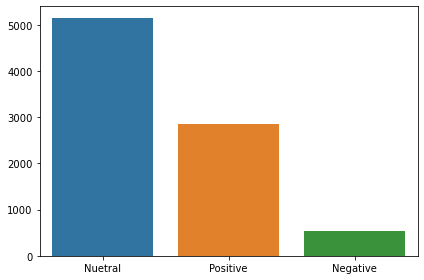

In [16]:
fig, ax = plt.subplots()

x=df['sentiment'].value_counts().index
y=df['sentiment'].value_counts().values

ax = sns.barplot(x,y)

plt.tight_layout()
fig.savefig('images/classes.png');

#### How are the length of the tweets distributed?

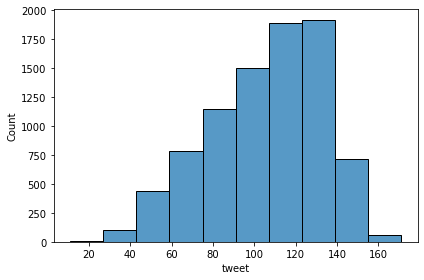

In [17]:
fig, ax = plt.subplots()

ax = sns.histplot(df['tweet'].str.len(), bins=10)

plt.tight_layout()
fig.savefig('images/character_hist.png');

The average tweet length is around 120 characters.

#### How many words are in the tweets?

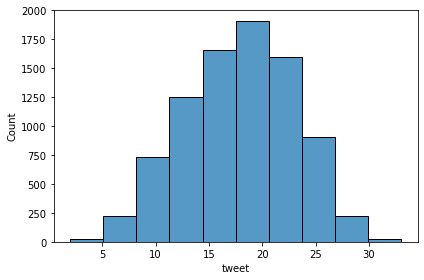

In [18]:
fig, ax = plt.subplots()

ax = sns.histplot(df['tweet'].str.split().map(lambda x: len(x)), bins=10)

plt.tight_layout()
fig.savefig('images/word_hist.png');

There looks to be around 20 words. 

#### What are the most common stop words?

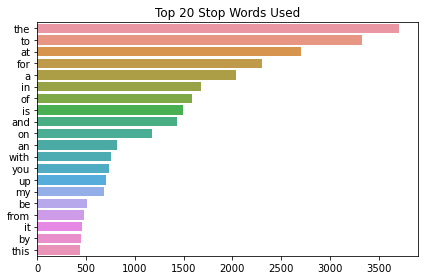

In [19]:
fig, ax = plt.subplots()

df['tweet'] = df['tweet'].astype(str)

corpus=[]
new= df['tweet'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict

dic=defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word]+=1
        
top25 = sorted(dic.items(), key=lambda item: item[1], reverse=True)[:20]

y_val = [x[0] for x in top25]
x_val = [x[1] for x in top25]

ax = sns.barplot(x_val,y_val, orient='h')
ax = ax.set_title('Top 20 Stop Words Used')

plt.tight_layout()
fig.savefig('images/stopwords.png');

The most common stopwords are the, to, at, and for, which is not suprising. 

#### How are the sentiments for brand?

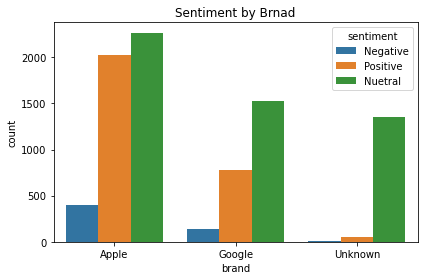

In [20]:
fig, ax = plt.subplots()

#Create the plot
ax = sns.countplot(x="brand", hue="sentiment", data=df)

ax.set_title("Sentiment by Brnad")

plt.tight_layout()
fig.savefig('images/brand.png');

Apple looks to have more negative and nuetral tweets than Google. 

#### How many negative sentiments are there for each Apple mention?

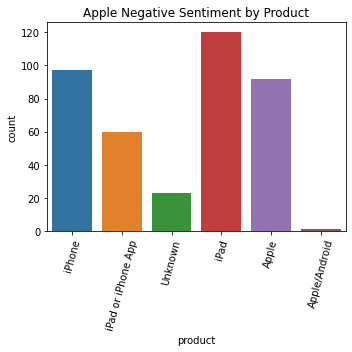

In [21]:
fig, ax = plt.subplots(figsize = (5,5))

apple_neg = df[(df['sentiment'] == 'Negative') & 
               (df['brand'] == 'Apple') &
               (df['product'] != 'Other Apple product or service') ]

#Create the plot
ax = sns.countplot(x="product", data=apple_neg)
plt.xticks(rotation=75)

ax.set_title("Apple Negative Sentiment by Product")

plt.tight_layout()
fig.savefig('images/apple_product.png');

The iphone and ipad look to have 

# Preprocess for modeling

In [22]:
#Convert the tweet column to a string
df['tweet'] = df['tweet'].astype(str)

In [23]:
def preprocess_tweet_text(tweet):
    '''This function converts each tweet to lowercase, 
       removes urls, hashtags and @ references, removes punctuation,
       removes stopwards, lemmatizes the words, and then joins the 
       words back together. 
       '''
    # Lowercase
    tweet = tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]
    #Return the words joined back together
    return " ".join(lemma_words)

In [24]:
#Apply the function to each tweet
df['tweet'] = df['tweet'].apply(preprocess_tweet_text)

# More EDA - Wordclouds

After we preprocessed, we wanted to take a look at wordclouds for negative tweets to highlight common words used to describe specific products. 

#### For negative tweets, how were users describing the iPad?

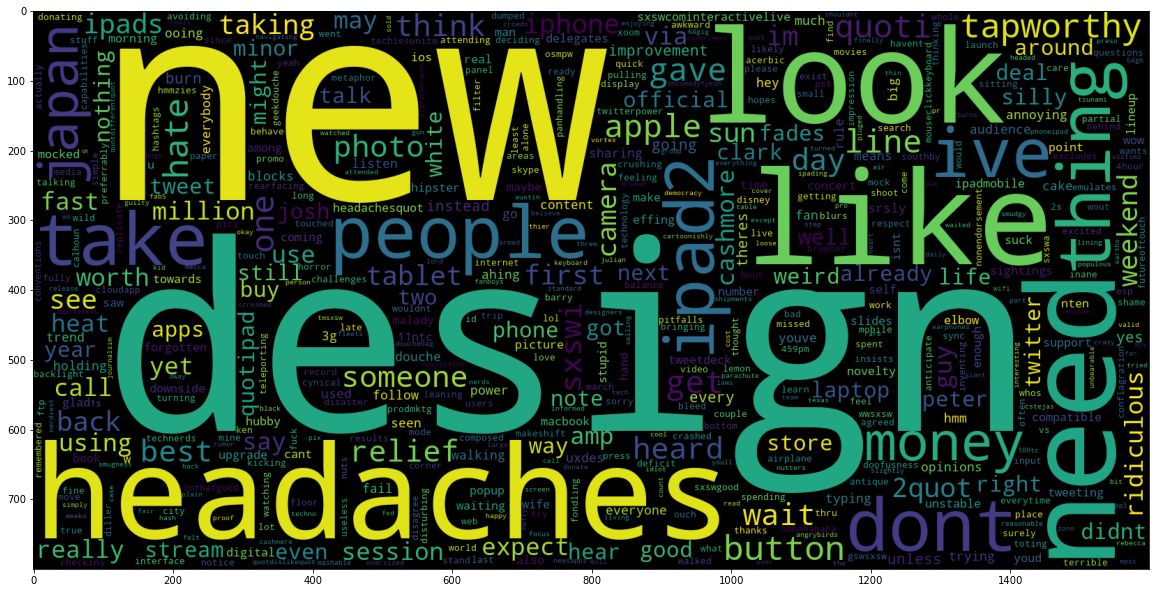

In [25]:
stopwords= ['sxsw', 'rt', 'ipad', 'link']

data_neg = df[(df['sentiment'] =='Negative') & (df['product']=='iPad')]
data_neg = data_neg['tweet']
plt.figure(figsize = (20,20))

wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False, stopwords=stopwords).generate(" ".join(data_neg))

plt.imshow(wc)

plt.savefig();

#### For negative tweets, how were users describing the iphone?

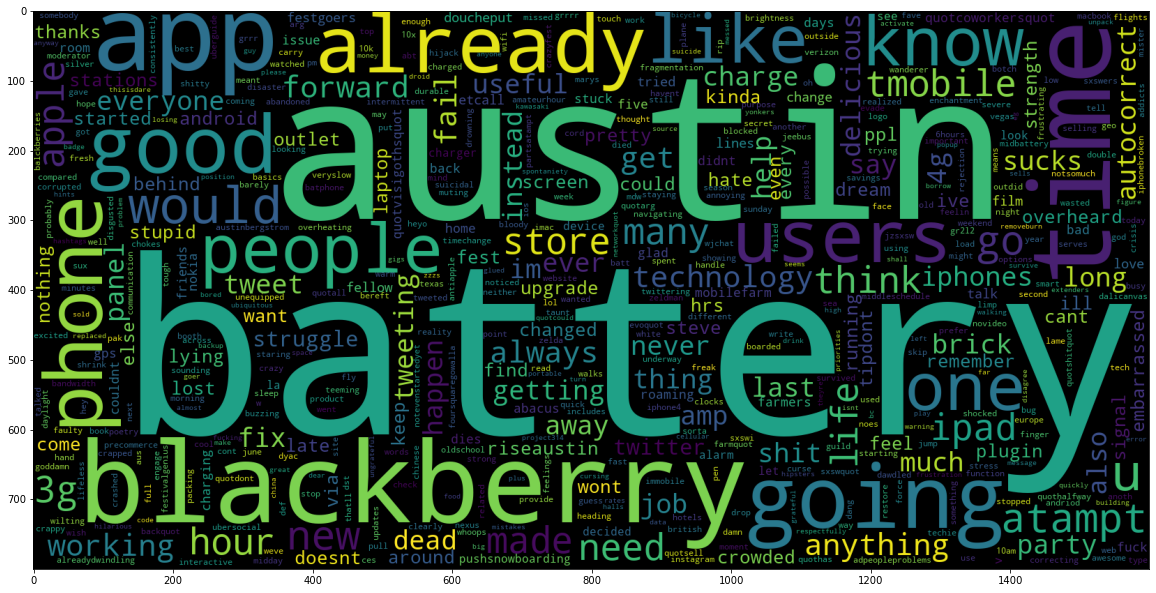

In [26]:
stopwords= ['sxsw', 'rt', 'iphone', 'link']

data_neg = df[(df['sentiment'] =='Negative') & (df['product']=='iPhone')]
data_neg = data_neg['tweet']
plt.figure(figsize = (20,20))

wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False, stopwords=stopwords).generate(" ".join(data_neg))

plt.imshow(wc);

#### For negative tweets, how were users describing the Google?

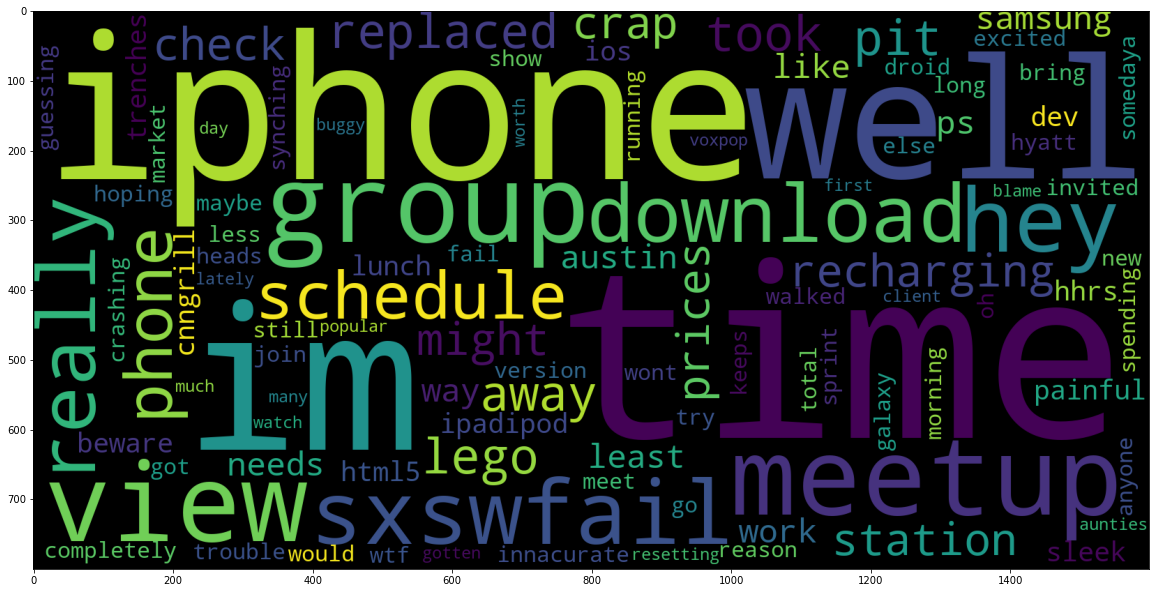

In [27]:
stopwords= ['sxsw', 'rt', 'google', 'link', 'android', 'app', 'apps']

data_neg = df[(df['sentiment'] =='Negative') & ((df['product']=='Android') | (df['product']=='Android App'))]
data_neg = data_neg['tweet']
plt.figure(figsize = (20,20))

wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False, stopwords=stopwords).generate(" ".join(data_neg))

plt.imshow(wc);

## Vectorize

In [28]:
# Convert string labels to 0,1,2
le = LabelEncoder()
df['target'] = le.fit_transform(df['sentiment'])

In [29]:
# Separate features and labels 
X = df['tweet']
y = df['target']

In [30]:
# Create test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

In [31]:
#Instantiate TFIDF vectorizer
vectorizer = TfidfVectorizer()
#Fit transform training data
tf_idf_train = vectorizer.fit_transform(X_train)
#Transform test data
tf_idf_test = vectorizer.transform(X_test)

# Modeling

### Dummy Model

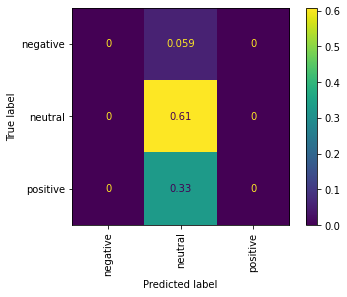

In [32]:
plot_confusion_matrix(DummyClassifier(strategy="most_frequent").fit(tf_idf_train , y_train), tf_idf_test, y_test, xticks_rotation='vertical', normalize = 'all', display_labels = ['negative', 'neutral', 'positive']);

The dummy model is showing that if we were to classify every tweet by the most common sentiment (neutral). We would be correct 61% of the time. This can definitley be improved upon through iterative model building. 

### Baseline First Simple Model - Random Forest

In [33]:
rf = RandomForestClassifier(random_state=42)
#fit on training data
rf.fit(tf_idf_train, y_train)
#get predictions
y_preds_train = rf.predict(tf_idf_train)
y_preds_test = rf.predict(tf_idf_test)

#### Training Predictions

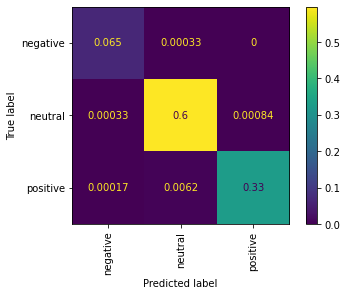

In [34]:
plot_confusion_matrix(rf, tf_idf_train, y_train, xticks_rotation='vertical', normalize='all', display_labels = ['negative', 'neutral', 'positive']);

In [35]:
print(classification_report(y_train, y_preds_train, target_names= ['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.99      0.99      0.99       393
     neutral       0.99      1.00      0.99      3581
    positive       1.00      0.98      0.99      2008

    accuracy                           0.99      5982
   macro avg       0.99      0.99      0.99      5982
weighted avg       0.99      0.99      0.99      5982



#### Testing Predictions

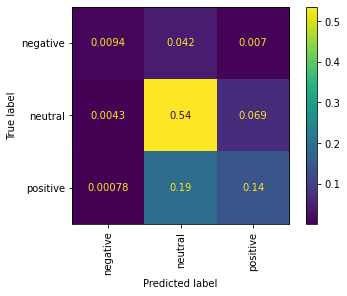

In [36]:
plot_confusion_matrix(rf, tf_idf_test, y_test, xticks_rotation='vertical', normalize='all', display_labels = ['negative', 'neutral', 'positive']);

In [37]:
print(classification_report(y_test, y_preds_test,target_names= ['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.65      0.16      0.26       151
     neutral       0.70      0.88      0.78      1561
    positive       0.65      0.43      0.52       853

    accuracy                           0.69      2565
   macro avg       0.67      0.49      0.52      2565
weighted avg       0.68      0.69      0.66      2565



We are focused on increasing the recall of the negative sentiment and on the baseline model the recall is .16.

### More models using Hyperparameter Tuning and Pipelines

In [38]:
# Naive Bayes pipeline setup
nb_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('SMOTE',SMOTE(random_state=42)),
 ('mnb', MultinomialNB())
])

# Randomforest pipeline setup
rf_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('SMOTE', SMOTE(random_state=42)),
 ('rf', RandomForestClassifier(random_state=42))
])

# Fit
nb_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

# Setting params for TFIDF Vectorizer gridsearch
nb_params = {
 'tvec__max_features':[500, 1000, 2000],
 'tvec__ngram_range': [(1, 1), (1, 2)]
}

# Setting up randomforest params
rf_params = {
 'tvec__max_features':[1000, 2000],
 'tvec__ngram_range': [(1, 1), (1, 2)],
 'rf__max_depth': [500, 1000],
 'rf__min_samples_split': [25,50],
 'rf__n_estimators': [500]
}

In [39]:
start = time.time()

# Setting up GridSearch for Randomforest
rf_gs = GridSearchCV(rf_pipe, 
                     param_grid=rf_params, 
                     cv = 5, 
                     verbose = 1, 
                     n_jobs = -1)

# Setting up GridSearch for NB
nb_gs = GridSearchCV(nb_pipe, 
                     param_grid=nb_params, 
                     cv = 5, 
                     verbose =1, 
                     n_jobs = -1)

# Fitting NB GS
nb_gs.fit(X_train, y_train)

# Fitting Randomforest
rf_gs.fit(X_train, y_train)

end = time.time()
print('Time it took to run the fittings: {}'.format(round(end-start),0) + ' seconds')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Time it took to run the fittings: 185 seconds


In [40]:
# Scoring Training data on NB
print('Training score for Naive Bayes: {}'.format(nb_gs.score(X_train, y_train)))

# Scoring Test data on NB
print('Testing score for Naive Bayes: {}'.format(nb_gs.score(X_test, y_test)))

# Scoring Training data on RandomForest
print('Training score for Random Forest: {}'.format(rf_gs.score(X_train, y_train)))

# Checking Test score on RandomForest
print('Testing score for Random Forest: {}'.format(rf_gs.score(X_test, y_test)))

Training score for Naive Bayes: 0.6915747241725175
Testing score for Naive Bayes: 0.5738791423001949
Training score for Random Forest: 0.9680708793045804
Testing score for Random Forest: 0.6791423001949318


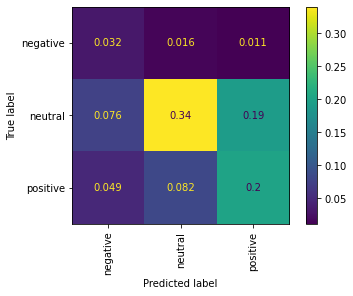

In [60]:
plot_confusion_matrix(nb_gs, X_test, y_test, xticks_rotation='vertical', normalize='all', display_labels = ['negative', 'neutral', 'positive']);

In [61]:
print(classification_report(y_test, nb_gs.predict(X_test),target_names= ['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.20      0.54      0.30       151
     neutral       0.78      0.56      0.65      1561
    positive       0.50      0.61      0.55       853

    accuracy                           0.57      2565
   macro avg       0.49      0.57      0.50      2565
weighted avg       0.65      0.57      0.59      2565



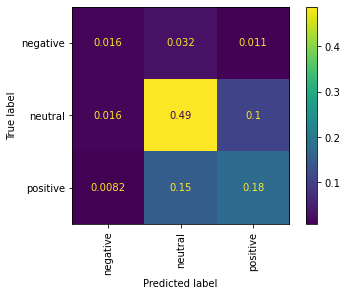

In [62]:
plot_confusion_matrix(rf_gs, X_test, y_test, xticks_rotation='vertical', normalize='all', display_labels = ['negative', 'neutral', 'positive']);

In [63]:
print(classification_report(y_test, rf_gs.predict(X_test),target_names= ['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.40      0.28      0.33       151
     neutral       0.73      0.80      0.76      1561
    positive       0.60      0.53      0.56       853

    accuracy                           0.68      2565
   macro avg       0.58      0.54      0.55      2565
weighted avg       0.67      0.68      0.67      2565



In [41]:
#Take a look at the best parameters from the gridsearch
rf_gs.best_params_

{'rf__max_depth': 500,
 'rf__min_samples_split': 25,
 'rf__n_estimators': 500,
 'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 1)}

In [64]:
#Take a look at the best parameters from the gridsearch
nb_gs.best_params_

{'tvec__max_features': 2000, 'tvec__ngram_range': (1, 1)}

The overall accuracy looks to be better for the Random forest model. You can see in the previous cell the best parameters used during gridsearch. The accuracy for the tuned random forest was slightly worse than the baseline random forest model. 

## Neural Network 

We also wanted to model using a Nueral Network to see if accuracy is improved. 

In [42]:
# Convert string labels to 0,1,2
le = LabelEncoder()
df['target'] = le.fit_transform(df['sentiment'])

In [43]:
# Transform the product labels to numerical values
lb = LabelBinarizer()
lb.fit(y_train)

#Transform x and y to categorical
y_train_lb = to_categorical(lb.transform(y_train))[:, :, 1]
y_test_lb = to_categorical(lb.transform(y_test))[:, :, 1]

#Extract the values for each in an array
X_train = X_train.values
X_test = X_test.values

In [44]:
#Crerate a total reviews variable
total_reviews = df['tweet'].values

#Instantiate a tokenizer
tokenizer_obj = Tokenizer(num_words=2000)

#Fit to  total reviews
tokenizer_obj.fit_on_texts(total_reviews)

In [45]:
#Define max_lengths
max_length = max([len(s.split()) for s in total_reviews])

#Define vocab size
vocab_size = len(tokenizer_obj.word_index) + 1

In [46]:
X_train_tokens = tokenizer_obj.texts_to_sequences(X_train)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_test)

#Create
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

#Resample
X_resampled, y_resampled = SMOTE().fit_resample(X_train_pad, y_train_lb)

In [47]:
EMBEDDING_DIM = 100

#Create the nueral network model
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [48]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 100)           1038200   
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                12768     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 1,051,067
Trainable params: 1,051,067
Non-trainable params: 0
_________________________________________________________________


In [50]:
weights = list(df['sentiment'].value_counts(normalize=True).values)
weights

[0.6016146016146016, 0.33473733473733475, 0.06364806364806365]

In [51]:
class_weights = class_weight.compute_class_weight('balanced',
                                               np.unique(y_train),
                                               y_train)

In [52]:
model.fit(X_train_pad, y_train_lb, batch_size=128, epochs=12, validation_data=(X_test_pad, y_test_lb), verbose=1, class_weight=class_weights)

Train on 5982 samples, validate on 2565 samples
Epoch 1/12
5982/5982 [==============================] - 11s 2ms/step - loss: 0.8755 - acc: 0.6606 - val_loss: 0.5707 - val_acc: 0.6667
Epoch 2/12
5982/5982 [==============================] - 9s 1ms/step - loss: 0.8622 - acc: 0.6621 - val_loss: 0.5582 - val_acc: 0.6667
Epoch 3/12
5982/5982 [==============================] - 8s 1ms/step - loss: 0.8608 - acc: 0.6615 - val_loss: 0.5652 - val_acc: 0.6667
Epoch 4/12
5982/5982 [==============================] - 8s 1ms/step - loss: 0.8439 - acc: 0.6662 - val_loss: 0.5653 - val_acc: 0.6667
Epoch 5/12
5982/5982 [==============================] - 8s 1ms/step - loss: 0.7700 - acc: 0.7259 - val_loss: 0.5679 - val_acc: 0.6667
Epoch 6/12
5982/5982 [==============================] - 7s 1ms/step - loss: 0.6972 - acc: 0.7658 - val_loss: 0.5646 - val_acc: 0.6672
Epoch 7/12
5982/5982 [==============================] - 7s 1ms/step - loss: 0.6315 - acc: 0.7909 - val_loss: 0.5652 - val_acc: 0.6667
Epoch 8/12
59

In [53]:
model.evaluate(X_test_pad, y_test_lb)

2565/2565 [==============================] - 1s 314us/step


[0.5513028544292116, 0.6671867966651917]

In [54]:
y_pred = model.predict(X_test_pad)
y_preds_nn = np.argmax(y_pred, axis=-1)

In [55]:
confusion_matrix(y_test, y_preds_nn)

array([[   0,  149,    2],
       [   0, 1543,   18],
       [   0,  807,   46]])

While the accuracy of the Nueral Network improved, it did not do a good job of predicting any negative tweets. 

# Final Model Evaluation - Tuned Random Forest Model

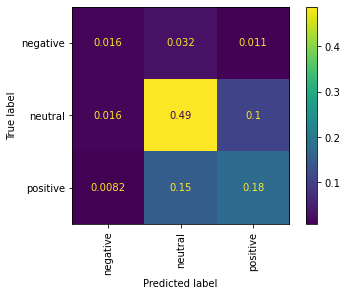

In [56]:
plot_confusion_matrix(rf_gs, X_test, y_test, xticks_rotation='vertical', normalize='all', display_labels = ['negative', 'neutral', 'positive']);

In [57]:
print(classification_report(y_test, rf_gs.predict(X_test),target_names= ['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.40      0.28      0.33       151
     neutral       0.73      0.80      0.76      1561
    positive       0.60      0.53      0.56       853

    accuracy                           0.68      2565
   macro avg       0.58      0.54      0.55      2565
weighted avg       0.67      0.68      0.67      2565



#### While our accuracy dipped from .69 in our baseline model to .68 in our tuned model, we did see a significant increase in our recall score. Our recall score increased from .16 to .28, an increase of 75%. This was the result of employing SMOTE, our resampling technique to create more observations of the negative class. 

### Feature importance

In [58]:
#Find importances
title = pd.DataFrame(rf_pipe.steps[2][1].feature_importances_, rf_pipe.steps[0][1].get_feature_names(), columns=['importance'])
title = title.sort_values('importance', ascending = False).head(10)
title

,importance
link,0.024860
sxsw,0.018422
ipad,0.017436
rt,0.013566
iphone,0.012953
apple,0.011431
app,0.008411
google,0.008095
store,0.007743
new,0.006002


#### What were the most important features in our tuned Random Forest Model?

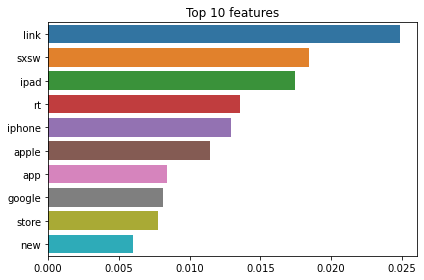

In [59]:
fig, ax = plt.subplots()

y = [x for x in title.index]
x = [y for i in title.values for y in i]

ax = sns.barplot(x, y, orient = 'h')
ax = ax.set_title('Top 10 features')

plt.tight_layout()
fig.savefig('images/feature_importance.png');

It looks like the specific product names were good predictors as well as the conference it was held at and the brand name. 

# Conclusions

**1. Focus on product mentions within negatvie tweets .** Iphone users were commenting a lot on the battery

**2. 2nd conclusion.** 

**3. 3rd conclusion.** 

# Next Steps

Further analyses could provide even more insight into how we can predict the sentiment of tweets: 

**Gather more tweets during that year** This can be done by finding tweets from the same year (around 2013) that mention the same products. This could provide for better modeling. 

**Get up to date tweets on similer products** This can be done by finding tweets for the latest realease of the ipad, iphone, and abndroid devices. 

**Gather data about products from similer companies** There may be tweets about the latest samsung, t-mobile, LG, Motorola phones that we could compare.